In [1]:
# Cell 1: imports and small utilities
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib

# helper: print nice section headers
def header(msg):
    print("\n" + "="*8 + " " + msg + " " + "="*8)

# ensure reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# Cell 2: find CSVs under repo and set RAW_PATH to the one you want
header("Working directory and CSV search")
print("cwd:", os.getcwd())
files = glob.glob("../**/*.csv", recursive=True) + glob.glob("./**/*.csv", recursive=True)
files = sorted(set(files))
print("CSV files found:")
for f in files:
    print(" -", f)

# Choose your raw file path (update if needed)
RAW_PATH = "../data/raw/PS_2026.02.07_05.49.41.csv"   # <-- change this if needed
print("\nUsing RAW_PATH:", RAW_PATH)


======== Working directory and CSV search ========
cwd: c:\Users\shish\Desktop\B13-ExoHabitAI\notebooks
CSV files found:
 - ..\data\preprocessed\preprocessed.csv
 - ..\data\raw\PS_2026.02.07_05.49.41.csv

Using RAW_PATH: ../data/raw/PS_2026.02.07_05.49.41.csv


In [3]:
# Cell 3: load raw CSV robustly
header("Load CSV")
if not os.path.exists(RAW_PATH):
    raise FileNotFoundError(f"Raw file not found: {RAW_PATH}")

# Try using pandas with comment='#' to skip header notes
raw_df = pd.read_csv(RAW_PATH, comment='#', skipinitialspace=True, low_memory=False)
print("Raw shape:", raw_df.shape)
# show top columns / first row
display(raw_df.head(6))


======== Load CSV ========
Raw shape: (39315, 289)


,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_dr2_id,gaia_dr3_id,default_flag,...,rowupdate,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec
0,1,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,Gaia DR3 3946945413106333696,1,...,2023-09-19,2023-08,2023-09-19,2.0,1.0,2.0,0.0,0.0,0.0,0.0
1,2,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,Gaia DR3 3946945413106333696,0,...,2014-05-14,2008-01,2014-05-14,2.0,1.0,2.0,0.0,0.0,0.0,0.0
2,3,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,Gaia DR3 3946945413106333696,0,...,2014-07-23,2011-08,2014-07-23,2.0,1.0,2.0,0.0,0.0,0.0,0.0
3,4,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,Gaia DR3 1696798367260229376,1,...,2018-09-04,2017-03,2018-09-06,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,5,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,Gaia DR3 1696798367260229376,0,...,2018-04-25,2011-08,2014-07-23,0.0,1.0,1.0,0.0,0.0,0.0,0.0
5,6,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,Gaia DR3 1696798367260229376,0,...,2018-04-25,2009-10,2014-05-14,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [4]:
# Cell 4: quick diagnostics
header("Quick diagnostics")
print("Columns:", len(raw_df.columns))
print("Row count:", len(raw_df))
print("Memory usage (MB):", raw_df.memory_usage(deep=True).sum() / 1024**2)
print("Preview column names (first 60):")
print(raw_df.columns[:60].tolist())


======== Quick diagnostics ========
Columns: 289
Row count: 39315
Memory usage (MB): 155.44463539123535
Preview column names (first 60):
['rowid', 'pl_name', 'hostname', 'pl_letter', 'hd_name', 'hip_name', 'tic_id', 'gaia_dr2_id', 'gaia_dr3_id', 'default_flag', 'sy_snum', 'sy_pnum', 'sy_mnum', 'cb_flag', 'discoverymethod', 'disc_year', 'disc_refname', 'disc_pubdate', 'disc_locale', 'disc_facility', 'disc_telescope', 'disc_instrument', 'rv_flag', 'pul_flag', 'ptv_flag', 'tran_flag', 'ast_flag', 'obm_flag', 'micro_flag', 'etv_flag', 'ima_flag', 'dkin_flag', 'soltype', 'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim', 'pl_masse', 'pl_masseerr1', 'pl_masseerr2', 'pl_masselim', 'pl_massj', 'pl_massjerr1', 'pl_massjerr2', 'pl_massjlim', 'pl_msinie']


In [5]:
# Cell 5: expected feature list (map these to your CSV's column names)
# Edit the names here to match your dataset's column names if they differ.
required_cols = {
    "pl_name":"pl_name",
    "pl_rade": "pl_rade",   # planet radius (Earth radii) - change if column is named differently
    "pl_bmasse": "pl_bmasse", # planet mass (Earth masses)
    "pl_orbper": "pl_orbper", # orbital period (days)
    "pl_orbsmax": "pl_orbsmax", # semi-major axis (AU)
    "pl_eqt": "pl_eqt",     # equilibrium temperature (K)
    "pl_dens": "pl_dens",   # planet density
    "st_teff": "st_teff",   # host star temperature (K)
    "st_lum": "st_lum",     # star luminosity
    "st_met": "st_met",     # star metallicity
    "st_spectype": "st_spectype"  # star type (categorical)
}
# Keep only those columns that exist in raw_df (avoid KeyError)
existing = [v for v in required_cols.values() if v in raw_df.columns]
print("Requested features mapping:")
for k,v in required_cols.items():
    print(f"  {k} -> {v} {'(FOUND)' if v in raw_df.columns else '(MISSING)'}")
print("\nSelecting columns that exist:", existing)
df = raw_df.copy()[existing]
print("Selected shape:", df.shape)
display(df.head(3))

Requested features mapping:
  pl_name -> pl_name (FOUND)
  pl_rade -> pl_rade (FOUND)
  pl_bmasse -> pl_bmasse (FOUND)
  pl_orbper -> pl_orbper (FOUND)
  pl_orbsmax -> pl_orbsmax (FOUND)
  pl_eqt -> pl_eqt (FOUND)
  pl_dens -> pl_dens (FOUND)
  st_teff -> st_teff (FOUND)
  st_lum -> st_lum (FOUND)
  st_met -> st_met (FOUND)
  st_spectype -> st_spectype (FOUND)

Selecting columns that exist: ['pl_name', 'pl_rade', 'pl_bmasse', 'pl_orbper', 'pl_orbsmax', 'pl_eqt', 'pl_dens', 'st_teff', 'st_lum', 'st_met', 'st_spectype']
Selected shape: (39315, 11)


,pl_name,pl_rade,pl_bmasse,pl_orbper,pl_orbsmax,pl_eqt,pl_dens,st_teff,st_lum,st_met,st_spectype
0,11 Com b,NaN,4914.898486,323.21,1.178,NaN,NaN,4874.0,1.97823,-0.26,G8 III
1,11 Com b,NaN,6165.600000,326.03,1.290,NaN,NaN,4742.0,2.24300,-0.35,G8 III
2,11 Com b,NaN,5434.700000,NaN,1.210,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print("\n===== Duplicate removal (by planet name) =====")

pid = 'pl_name'

if pid in df.columns:
    before = len(df)

    important_cols = ['pl_rade','pl_bmasse','pl_orbper','pl_orbsmax','pl_eqt','st_teff']
    df['null_count'] = df[important_cols].isnull().sum(axis=1)

    df = (
        df.sort_values([pid, 'null_count'])
          .drop_duplicates(subset=[pid], keep='first')
          .drop(columns='null_count')
          .reset_index(drop=True)
    )

    after = len(df)
    print(f"Removed {before - after} duplicate rows")

else:
    before = len(df)
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Removed {before - len(df)} exact duplicates")

print("Current df shape:", df.shape)


===== Duplicate removal (by planet name) =====
Removed 33215 duplicate rows
Current df shape: (6100, 11)


In [10]:
# Cell 7: drop columns with very high missing ratio (we kept only our required features, but run generic checks)
header("Missingness & summary stats")

# summary stats
display(df.describe(include='all').T)

# missing counts
missing_per_col = df.isnull().sum().sort_values(ascending=False)
print("\nMissing values per column:\n", missing_per_col)

# drop columns with > 85% missing (if any)
threshold_col = 0.85
cols_to_drop = (df.isnull().mean() > threshold_col)
cols_drop_list = list(cols_to_drop[cols_to_drop].index)
if cols_drop_list:
    print("Dropping columns with >85% missing:", cols_drop_list)
    df = df.drop(columns=cols_drop_list)
else:
    print("No columns dropped for high missing ratio.")

# Optionally drop rows that are almost completely empty (e.g., require at least 50% nonnull)
min_non_null = int(0.5 * df.shape[1])
before = len(df)
df = df.dropna(thresh=min_non_null).reset_index(drop=True)
after = len(df)
print(f"Dropped rows with <50% non-null values: {before-after}")
print("Shape after cleaning:", df.shape)


======== Missingness & summary stats ========


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
pl_name,6100,6100,11 Com b,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pl_rade,4575.0,NaN,NaN,NaN,6.099246,73.13374,0.3098,1.59,2.415,4.23,3791.05
pl_bmasse,2894.0,NaN,NaN,NaN,812.863446,1644.247203,0.02,14.3025,197.051806,731.008084,22934.497849
pl_orbper,5768.0,NaN,NaN,NaN,74205.618805,5295615.590844,0.090706,4.352093,11.091943,39.461614,402000000.0
pl_orbsmax,5749.0,NaN,NaN,NaN,15.677678,351.495674,0.0044,0.0525,0.102,0.3002,19000.0
pl_eqt,4444.0,NaN,NaN,NaN,909.052363,465.502406,34.0,567.75,811.0,1162.25,4050.0
pl_dens,1191.0,NaN,NaN,NaN,5.360574,60.336977,0.03,0.5335,1.31,3.415,2000.0
st_teff,5617.0,NaN,NaN,NaN,5425.700452,1742.182865,415.0,4928.0,5576.0,5952.0,57000.0
st_lum,1473.0,NaN,NaN,NaN,-0.187467,1.094628,-3.28067,-0.79615,-0.02687,0.43457,3.26076
st_met,4811.0,NaN,NaN,NaN,-0.023885,0.23192,-1.46,-0.16,-0.01,0.14,0.6



Missing values per column:
 pl_dens        4909
st_spectype    4699
st_lum         4627
pl_bmasse      3206
pl_eqt         1656
pl_rade        1525
st_met         1289
st_teff         483
pl_orbsmax      351
pl_orbper       332
pl_name           0
dtype: int64
No columns dropped for high missing ratio.
Dropped rows with <50% non-null values: 438
Shape after cleaning: (5662, 11)



======== Missing value heatmap (sample / truncated if large) ========


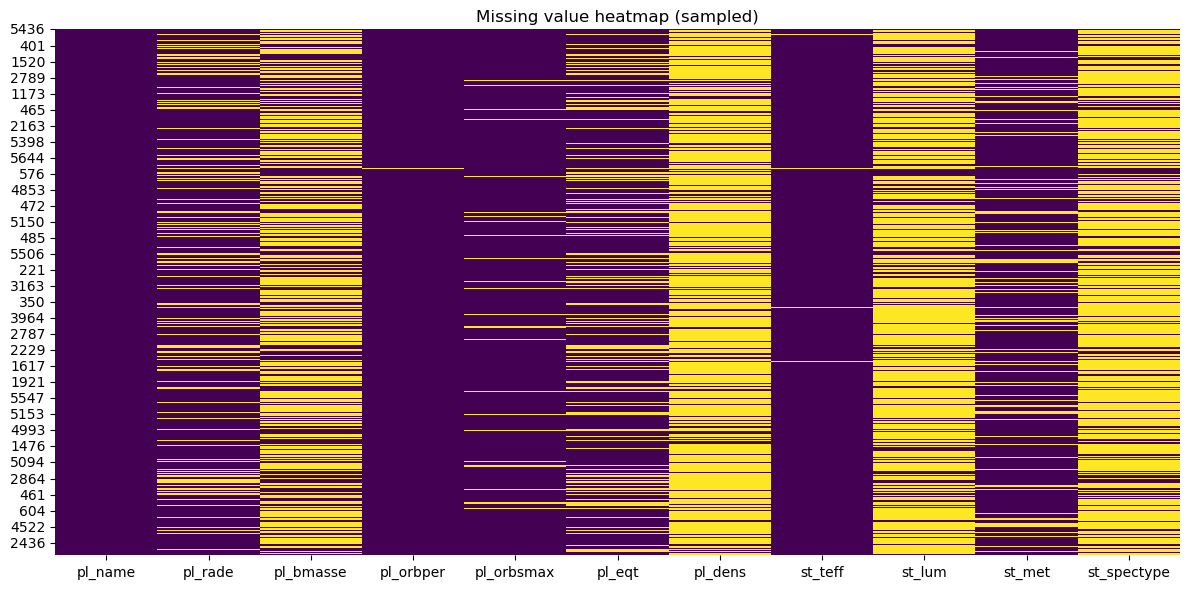

Saved missing summary to ../notebooks/summary_missing_preprocessed.csv


In [11]:
# Cell 8: missing value heatmap
header("Missing value heatmap (sample / truncated if large)")
# For very large df, sample a subset for visualization
vis_df = df if len(df) <= 2000 else df.sample(n=2000, random_state=RANDOM_STATE)
plt.figure(figsize=(12,6))
sns.heatmap(vis_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing value heatmap (sampled)" if len(df)>2000 else "Missing value heatmap")
plt.tight_layout()
plt.show()

# Save simple missing summary to notebook artifacts (optional)
missing_summary = df.isnull().sum().to_frame("missing_count")
missing_summary['missing_pct'] = missing_summary['missing_count'] / len(df) * 100
missing_summary.to_csv("../notebooks/summary_missing_preprocessed.csv")
print("Saved missing summary to ../notebooks/summary_missing_preprocessed.csv")

In [12]:
# Cell 9: Impute missing values
header("Impute missing values")

# numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)
# fill numeric with median
medians = df[numeric_cols].median()
df.loc[:, numeric_cols] = df[numeric_cols].fillna(medians)

# categorical columns: fill with mode or 'Unknown'
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", cat_cols)
for c in cat_cols:
    if not df[c].mode().empty:
        mode_val = df[c].mode().iloc[0]
    else:
        mode_val = "Unknown"
    df.loc[:, c] = df[c].fillna(mode_val)

print("Remaining missing values:", df.isnull().sum().sum())


======== Impute missing values ========
Numeric columns: ['pl_rade', 'pl_bmasse', 'pl_orbper', 'pl_orbsmax', 'pl_eqt', 'pl_dens', 'st_teff', 'st_lum', 'st_met']
Categorical columns: ['pl_name', 'st_spectype']
Remaining missing values: 0


In [13]:
# Cell 10: Outlier detection helpers
header("Outlier detection (Z-score & IQR)")

from scipy import stats

def iqr_outliers(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k*iqr
    upper = q3 + k*iqr
    return lower, upper

def zscore_outliers(series, thresh=3):
    z = np.abs(stats.zscore(series.dropna()))
    mask = (z > thresh)
    return series.index[mask]

# Example: check pl_rade for negative or implausible values
checks = []
if 'pl_rade' in df.columns:
    # remove negative radii
    neg_count = (df['pl_rade'] <= 0).sum()
    checks.append(f"pl_rade <=0 : {neg_count}")
    df = df[df['pl_rade'] > 0].copy()
    # cap extreme (example cap at 30 Earth radii as unrealistic for rocky planets; tune as needed)
    cap = 30
    df.loc[df['pl_rade'] > cap, 'pl_rade'] = cap

# IQR capping example for pl_bmasse
if 'pl_bmasse' in df.columns:
    lower, upper = iqr_outliers(df['pl_bmasse'].dropna(), k=1.5)
    df.loc[df['pl_bmasse'] < lower, 'pl_bmasse'] = lower
    df.loc[df['pl_bmasse'] > upper, 'pl_bmasse'] = upper
    checks.append(f"pl_bmasse IQR lower/upper: {lower:.2f}/{upper:.2f}")

print("Outlier checks:", checks)
print("Shape after outlier handling:", df.shape)


======== Outlier detection (Z-score & IQR) ========
Outlier checks: ['pl_rade <=0 : 0', 'pl_bmasse IQR lower/upper: 194.51/194.51']
Shape after outlier handling: (5662, 11)


In [14]:
# Cell 11: Unit standardization scaffold
header("Unit standardization")

# NOTE: This cell provides examples. Inspect column metadata / docs to confirm original units.
# Example conversions if needed:
# - radius given in km -> convert to Earth radii (1 Earth radius = 6371 km)
# - mass given in Jupiter masses -> convert to Earth masses (1 Mj = 317.8 Me)
# - distance given in km -> convert to AU (1 AU = 1.496e8 km)
# Adjust conversions to match your dataset.

# Example:
if 'pl_rade_km' in df.columns and 'pl_rade' not in df.columns:
    df['pl_rade'] = df['pl_rade_km'] / 6371.0  # km -> Earth radii

# If mass is in Jupiter masses column 'pl_bmassj', convert:
if 'pl_bmassj' in df.columns and 'pl_bmasse' not in df.columns:
    df['pl_bmasse'] = df['pl_bmassj'] * 317.8  # Mj -> Earth masses

# Examples above are placeholders — replace with actual columns/logic for your data.
print("Unit standardization: verify manually that units are consistent.")


======== Unit standardization ========
Unit standardization: verify manually that units are consistent.


In [15]:
# Cell 12: Feature engineering - Habitability score & indices
header("Feature engineering: habitability, stellar compatibility, orbital stability")

# 1) habitability_score — simple physics-inspired composite (range 0..1)
def scaled_proximity(value, ideal, width):
    # returns 1 at ideal, decays to 0 outside +/- width
    return np.exp(-0.5 * ((value - ideal)/width)**2)

# Parameters (example):
ideal_temp = 288   # K, Earth-like equilibrium temp ~288K
temp_width = 50
ideal_radius = 1.0
radius_width = 0.8
ideal_dist = None  # if you have semi-major axis and luminosity you could compute habitable zone

# compute temp score
if 'pl_eqt' in df.columns:
    df['score_temp'] = scaled_proximity(df['pl_eqt'], ideal_temp, temp_width)
else:
    df['score_temp'] = 0.5

# radius score
if 'pl_rade' in df.columns:
    df['score_radius'] = scaled_proximity(df['pl_rade'], ideal_radius, radius_width)
else:
    df['score_radius'] = 0.5

# distance proxy: use semi-major axis and st_lum to approximate habitable zone (simple)
if 'pl_orbsmax' in df.columns and 'st_lum' in df.columns:
    # simple estimate: habitable zone approx at sqrt(L) AU
    hz_center = np.sqrt(df['st_lum'].replace(0, np.nan)).fillna(1.0)
    df['score_dist'] = scaled_proximity(df['pl_orbsmax'], hz_center, width=hz_center*0.5)
else:
    df['score_dist'] = 0.5

# stellar compatibility: normalized host star temperature proximity to Sun (~5778 K) and luminosity
if 'st_teff' in df.columns:
    df['score_stellar_temp'] = scaled_proximity(df['st_teff'], 5778, 1000)
else:
    df['score_stellar_temp'] = 0.5

if 'st_lum' in df.columns:
    # prefer stars with modest luminosities (not extremely luminous or extremely faint)
    df['score_stellar_lum'] = scaled_proximity(df['st_lum'], 1.0, 2.0)
else:
    df['score_stellar_lum'] = 0.5

# combine habitability score (weighted average)
weights = {
    'score_temp': 0.35,
    'score_radius': 0.25,
    'score_dist': 0.20,
    'score_stellar_temp': 0.10,
    'score_stellar_lum': 0.10
}
df['habitability_score'] = (
    df['score_temp'] * weights['score_temp'] +
    df['score_radius'] * weights['score_radius'] +
    df['score_dist'] * weights['score_dist'] +
    df['score_stellar_temp'] * weights['score_stellar_temp'] +
    df['score_stellar_lum'] * weights['score_stellar_lum']
)

# Orbital stability factor (simple proxy using orbit period and semi-major axis)
if 'pl_orbper' in df.columns and 'pl_orbsmax' in df.columns:
    df['orbital_stability'] = 1.0 / (1.0 + np.abs(df['pl_orbper'] / (df['pl_orbsmax']+1e-6)))
else:
    df['orbital_stability'] = 0.5

# Stellar compatibility index
df['stellar_compatibility'] = 0.6 * df['score_stellar_temp'] + 0.4 * df['score_stellar_lum']

print("Feature engineering added: habitability_score, orbital_stability, stellar_compatibility")
display(df[['habitability_score','orbital_stability','stellar_compatibility']].head())


======== Feature engineering: habitability, stellar compatibility, orbital stability ========
Feature engineering added: habitability_score, orbital_stability, stellar_compatibility


c:\Users\shish\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,habitability_score,orbital_stability,stellar_compatibility
0,0.396636,0.003631,0.753649
1,0.282810,0.002955,0.526927
2,0.349088,0.004133,0.770021
3,0.224962,0.001619,0.868812
4,0.323037,0.002075,0.950369


In [16]:
# Cell 13: One-hot encode star spectral type (if present)
header("Categorical encoding")
if 'st_spectype' in df.columns:
    # simplify spectral types: extract first letter (G, K, M, F, etc.)
    df['st_spectype_simple'] = df['st_spectype'].astype(str).str.strip().str[0].replace({'n':'Unknown'})
    # only keep common classes
    allowed = ['O','B','A','F','G','K','M']
    df['st_spectype_simple'] = df['st_spectype_simple'].where(df['st_spectype_simple'].isin(allowed), 'Other')
    df = pd.get_dummies(df, columns=['st_spectype_simple'], prefix='spec', drop_first=True)
    print("One-hot encoded st_spectype_simple -> spec_*")
else:
    print("No st_spectype column to encode.")

# Final feature list for ML
feature_cols = [c for c in df.columns if c not in ['pl_name','pl_letter','some_other_id_if_exists']]
print("Candidate features for ML:", feature_cols)


======== Categorical encoding ========
One-hot encoded st_spectype_simple -> spec_*
Candidate features for ML: ['pl_rade', 'pl_bmasse', 'pl_orbper', 'pl_orbsmax', 'pl_eqt', 'pl_dens', 'st_teff', 'st_lum', 'st_met', 'st_spectype', 'score_temp', 'score_radius', 'score_dist', 'score_stellar_temp', 'score_stellar_lum', 'habitability_score', 'orbital_stability', 'stellar_compatibility', 'spec_B', 'spec_F', 'spec_G', 'spec_K', 'spec_M', 'spec_Other']


In [ ]:
# Cell 14: feature scaling
header("Feature scaling")
# pick numeric feature subset you want to scale (including engineered features)
numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in ['habitability_score']]  # habitability_score already in 0..1
print("Numeric columns to scale:", numeric_cols)

scaler = StandardScaler()
df.loc[:, numeric_cols] = scaler.fit_transform(df[numeric_cols])
joblib.dump(scaler, "../data/preprocessed/scaler.joblib")
print("Scaler saved to ../data/preprocessed/scaler.joblib")


======== Feature scaling ========
Numeric columns to scale: ['pl_rade', 'pl_bmasse', 'pl_orbper', 'pl_orbsmax', 'pl_eqt', 'pl_dens', 'st_teff', 'st_lum', 'st_met', 'score_temp', 'score_radius', 'score_dist', 'score_stellar_temp', 'score_stellar_lum', 'orbital_stability', 'stellar_compatibility']
Scaler saved to ../data/preprocessed/scaler.joblib


In [21]:
# ===== Cell 15 — Create binary target & final cleanup =====

# Create target
if 'habitability_score' in df.columns:
    df['habitable_binary'] = (df['habitability_score'] >= 0.6).astype(int)
else:
    df['habitable_binary'] = (
        (df['pl_eqt'].between(200, 350)) &
        (df['pl_rade'].between(0.5, 2))
    ).astype(int)

print("Target distribution:\n", df['habitable_binary'].value_counts(dropna=False))

# FINAL CLEANUP
df = df.drop_duplicates().reset_index(drop=True)
df = df.fillna(0)

# Final checks
print("\nFinal shape:", df.shape)
print("Total missing values:", df.isnull().sum().sum())
print("Duplicate rows remaining:", df.duplicated().sum())

Target distribution:
 habitable_binary
0    591
Name: count, dtype: int64

Final shape: (591, 26)
Total missing values: 0
Duplicate rows remaining: 0


In [22]:
# Save ONLY the final cleaned dataset
df.to_csv("../data/preprocessed/preprocessed.csv", index=False)

print("File saved successfully.")
print("Final shape:", df.shape)

File saved successfully.
Final shape: (591, 26)


In [23]:
import os
os.path.exists("../data/preprocessed/preprocessed.csv")

True